In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import seaborn as sns

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")


In [2]:
class GaussianVI(nn.Module):
    """
    Variational Inference with a Gaussian approximation using PyTorch.
    Optimizes mean and log-variance parameters to minimize KL divergence.
    """

    def __init__(self, initial_mean=0.0, initial_log_var=0.0):
        super(GaussianVI, self).__init__()
        # Parameters to optimize
        self.mean = nn.Parameter(torch.tensor(initial_mean, dtype=torch.float32))
        self.log_var = nn.Parameter(torch.tensor(initial_log_var, dtype=torch.float32))

    def log_prob(self, x):
        """Compute log probability density of x under current Gaussian"""
        var = torch.exp(self.log_var)
        return -0.5 * (torch.log(2 * torch.pi * var) + (x - self.mean) ** 2 / var)

    def sample(self, n_samples):
        """Sample from current Gaussian distribution"""
        std = torch.sqrt(torch.exp(self.log_var))
        eps = torch.randn(n_samples)
        return self.mean + std * eps

    def pdf(self, x):
        """Probability density function"""
        return torch.exp(self.log_prob(x))

    def get_params(self):
        """Return current mean and standard deviation"""
        return self.mean.item(), torch.sqrt(torch.exp(self.log_var)).item()

In [3]:
def target_log_density(x, mixture_weights=None, mixture_means=None, mixture_stds=None):
    """
    Target distribution: Gaussian mixture model
    Default is a bimodal mixture for interesting visualization
    """
    if mixture_weights is None:
        mixture_weights = [0.4, 0.6]
    if mixture_means is None:
        mixture_means = [-2.0, 3.0]
    if mixture_stds is None:
        mixture_stds = [0.8, 1.2]

    # Convert to tensors if they aren't already
    x = torch.as_tensor(x, dtype=torch.float32)

    # Convert all parameters to tensors
    mixture_weights = torch.tensor(mixture_weights, dtype=torch.float32)
    mixture_means = torch.tensor(mixture_means, dtype=torch.float32)
    mixture_stds = torch.tensor(mixture_stds, dtype=torch.float32)

    # Compute mixture log probabilities
    log_probs = []
    for w, mu, sigma in zip(mixture_weights, mixture_means, mixture_stds):
        # Log probability of Gaussian component
        log_prob = -0.5 * torch.log(2 * torch.pi * sigma ** 2) - 0.5 * (x - mu) ** 2 / sigma ** 2
        log_probs.append(torch.log(w) + log_prob)

    # Log-sum-exp for numerical stability
    log_probs = torch.stack(log_probs, dim=0)
    return torch.logsumexp(log_probs, dim=0)

In [11]:
def compute_kl_loss(vi_model, target_log_density_fn, n_samples=1000):
    """
    Compute KL divergence using Monte Carlo estimation:
    KL(q||p) = E_q[log q(x) - log p(x)]
    """
    # Sample from variational distribution
    samples = vi_model.sample(n_samples)

    # Compute log probabilities
    q_log_prob = vi_model.log_prob(samples)  # log q(x)
    p_log_prob = target_log_density_fn(samples)  # log p(x)

    # KL divergence estimate
    kl_div = torch.mean(2*q_log_prob - p_log_prob)
    return kl_div


In [12]:
def run_variational_inference(target_log_density_fn, n_iterations=1000, lr=0.01,
                              initial_mean=0.0, initial_log_var=0.0, random_seed=42):
    """
    Run variational inference optimization
    """
    # Set random seed for reproducibility
    torch.manual_seed(random_seed)
    np.random.seed(random_seed)

    # Initialize model and optimizer
    vi_model = GaussianVI(initial_mean, initial_log_var)
    optimizer = optim.Adam(vi_model.parameters(), lr=lr)

    # Track optimization trajectory
    means = []
    stds = []
    losses = []

    print("Starting Variational Inference...")
    print(f"Initial: mean={vi_model.mean.item():.3f}, std={vi_model.get_params()[1]:.3f}")

    for i in range(n_iterations):
        optimizer.zero_grad()

        # Compute loss (KL divergence)
        loss = compute_kl_loss(vi_model, target_log_density_fn)
        loss.backward()
        optimizer.step()

        # Track progress
        mean, std = vi_model.get_params()
        means.append(mean)
        stds.append(std)
        losses.append(loss.item())

        if (i + 1) % 100 == 0:
            print(f"Iteration {i + 1}: Loss={loss.item():.4f}, mean={mean:.3f}, std={std:.3f}")

    final_mean, final_std = vi_model.get_params()
    print(f"Final: mean={final_mean:.3f}, std={final_std:.3f}")

    return vi_model, np.array(means), np.array(stds), np.array(losses)

In [13]:

def create_visualization(vi_model, means_trajectory, stds_trajectory, losses,
                         target_log_density_fn, mixture_means=[-2.0, 3.0], mixture_stds=[0.8, 1.2]):
    """
    Create comprehensive visualization of the optimization process
    """
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

    # Set up x range for plotting
    x_range = np.linspace(-6, 6, 1000)

    # 1. Final distributions comparison
    with torch.no_grad():
        target_log_probs = target_log_density_fn(torch.tensor(x_range))
        target_probs = torch.exp(target_log_probs).numpy()

        vi_log_probs = vi_model.log_prob(torch.tensor(x_range))
        vi_probs = torch.exp(vi_log_probs).numpy()

    ax1.plot(x_range, target_probs, 'r-', linewidth=2, label='Target (GMM)', alpha=0.8)
    ax1.plot(x_range, vi_probs, 'b--', linewidth=2, label='VI Approximation', alpha=0.8)
    ax1.fill_between(x_range, target_probs, alpha=0.3, color='red')
    ax1.fill_between(x_range, vi_probs, alpha=0.3, color='blue')
    ax1.set_xlabel('x')
    ax1.set_ylabel('Density')
    ax1.set_title('Final Approximation vs Target')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # 2. Parameter trajectories
    iterations = np.arange(len(means_trajectory))
    ax2.plot(iterations, means_trajectory, 'g-', linewidth=2, label='Mean', alpha=0.8)
    ax2_twin = ax2.twinx()
    ax2_twin.plot(iterations, stds_trajectory, 'orange', linewidth=2, label='Std Dev', alpha=0.8)

    ax2.set_xlabel('Iteration')
    ax2.set_ylabel('Mean', color='g')
    ax2_twin.set_ylabel('Standard Deviation', color='orange')
    ax2.set_title('Parameter Evolution')
    ax2.grid(True, alpha=0.3)

    # Add legends
    lines1, labels1 = ax2.get_legend_handles_labels()
    lines2, labels2 = ax2_twin.get_legend_handles_labels()
    ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

    # 3. Loss trajectory
    ax3.plot(losses, 'purple', linewidth=2, alpha=0.8)
    ax3.set_xlabel('Iteration')
    ax3.set_ylabel('KL Divergence')
    ax3.set_title('Optimization Loss (KL Divergence)')
    ax3.grid(True, alpha=0.3)

    # 4. Trajectory in parameter space
    ax4.plot(means_trajectory, stds_trajectory, 'b-', alpha=0.6, linewidth=1)
    ax4.scatter(means_trajectory[0], stds_trajectory[0], color='green', s=100,
                marker='o', label='Start', zorder=5)
    ax4.scatter(means_trajectory[-1], stds_trajectory[-1], color='red', s=100,
                marker='*', label='End', zorder=5)

    # Add some trajectory points
    n_points = min(10, len(means_trajectory))
    indices = np.linspace(0, len(means_trajectory) - 1, n_points, dtype=int)
    ax4.scatter(means_trajectory[indices], stds_trajectory[indices],
                c=indices, cmap='viridis', s=30, alpha=0.7, zorder=3)

    ax4.set_xlabel('Mean')
    ax4.set_ylabel('Standard Deviation')
    ax4.set_title('Trajectory in Parameter Space')
    ax4.legend()
    ax4.grid(True, alpha=0.3)

    plt.tight_layout()
    return fig


def create_evolution_sequence(means_trajectory, stds_trajectory, target_log_density_fn,
                              n_snapshots=8):
    """
    Create a sequence of plots showing the evolution of the approximation
    """
    x_range = np.linspace(-6, 6, 1000)

    # Target distribution (static)
    with torch.no_grad():
        target_log_probs = target_log_density_fn(torch.tensor(x_range))
        target_probs = torch.exp(target_log_probs).numpy()

    # Select snapshots evenly spaced throughout the optimization
    n_iterations = len(means_trajectory)
    snapshot_indices = np.linspace(0, n_iterations - 1, n_snapshots, dtype=int)

    # Calculate subplot layout
    n_cols = 4
    n_rows = (n_snapshots + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4 * n_rows))
    if n_rows == 1:
        axes = axes.reshape(1, -1)

    # Flatten axes for easier indexing
    axes_flat = axes.flatten()

    # Find y-axis limits for consistent scaling
    y_min, y_max = 0, max(target_probs) * 1.1

    for i, (ax, idx) in enumerate(zip(axes_flat, snapshot_indices)):
        # Get parameters at this snapshot
        mean = means_trajectory[idx]
        std = stds_trajectory[idx]

        # Compute VI distribution at this iteration
        vi_probs = norm.pdf(x_range, mean, std)

        # Plot target distribution
        ax.plot(x_range, target_probs, 'r-', linewidth=2, label='Target', alpha=0.8)
        ax.fill_between(x_range, target_probs, alpha=0.2, color='red')

        # Plot VI approximation
        ax.plot(x_range, vi_probs, 'b--', linewidth=2, label='VI Approx', alpha=0.8)
        ax.fill_between(x_range, vi_probs, alpha=0.3, color='blue')

        # Formatting
        ax.set_xlim(-6, 6)
        ax.set_ylim(y_min, y_max)
        ax.set_title(f'Iteration {idx}\nμ={mean:.3f}, σ={std:.3f}', fontsize=10)
        ax.grid(True, alpha=0.3)

        # Only add labels to bottom row and left column
        if i >= len(axes_flat) - n_cols:
            ax.set_xlabel('x')
        if i % n_cols == 0:
            ax.set_ylabel('Density')

        # Add legend only to first subplot
        if i == 0:
            ax.legend(fontsize=9)

    # Hide unused subplots
    for i in range(n_snapshots, len(axes_flat)):
        axes_flat[i].set_visible(False)

    plt.tight_layout()
    return fig


=== Gaussian Variational Inference with PyTorch ===

Starting Variational Inference...
Initial: mean=-3.000, std=1.414
Iteration 100: Loss=-1.0292, mean=-0.512, std=1.720
Iteration 200: Loss=-1.6869, mean=1.202, std=2.093
Iteration 300: Loss=-1.6516, mean=1.443, std=2.131
Iteration 400: Loss=-1.7405, mean=1.460, std=2.092
Iteration 500: Loss=-1.7074, mean=1.428, std=2.097
Iteration 600: Loss=-1.7670, mean=1.461, std=2.134
Iteration 700: Loss=-1.7242, mean=1.470, std=2.078
Iteration 800: Loss=-1.7244, mean=1.455, std=2.139
Iteration 900: Loss=-1.5678, mean=1.426, std=2.142
Iteration 1000: Loss=-1.7866, mean=1.437, std=2.097
Iteration 1100: Loss=-1.7613, mean=1.416, std=2.047
Iteration 1200: Loss=-1.7294, mean=1.467, std=2.102
Iteration 1300: Loss=-1.6802, mean=1.484, std=2.070
Iteration 1400: Loss=-1.7689, mean=1.466, std=2.096
Iteration 1500: Loss=-1.7390, mean=1.471, std=2.094
Final: mean=1.471, std=2.094

Creating visualization...


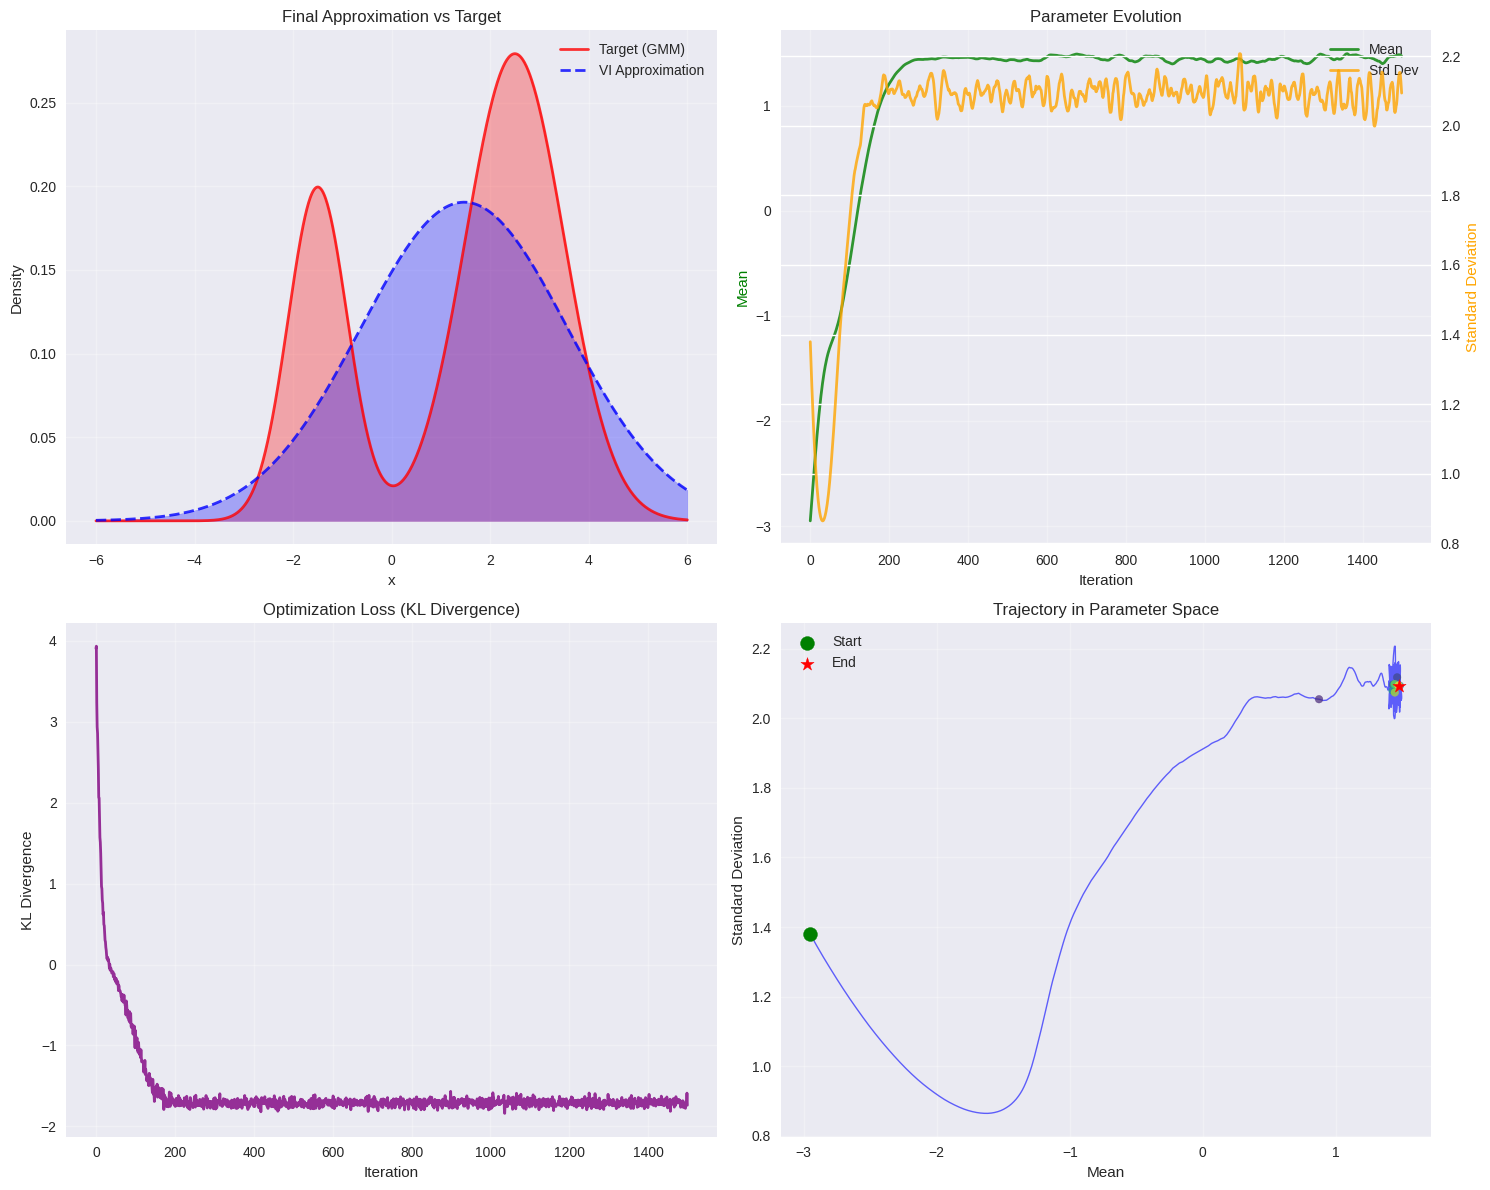

Creating evolution sequence...


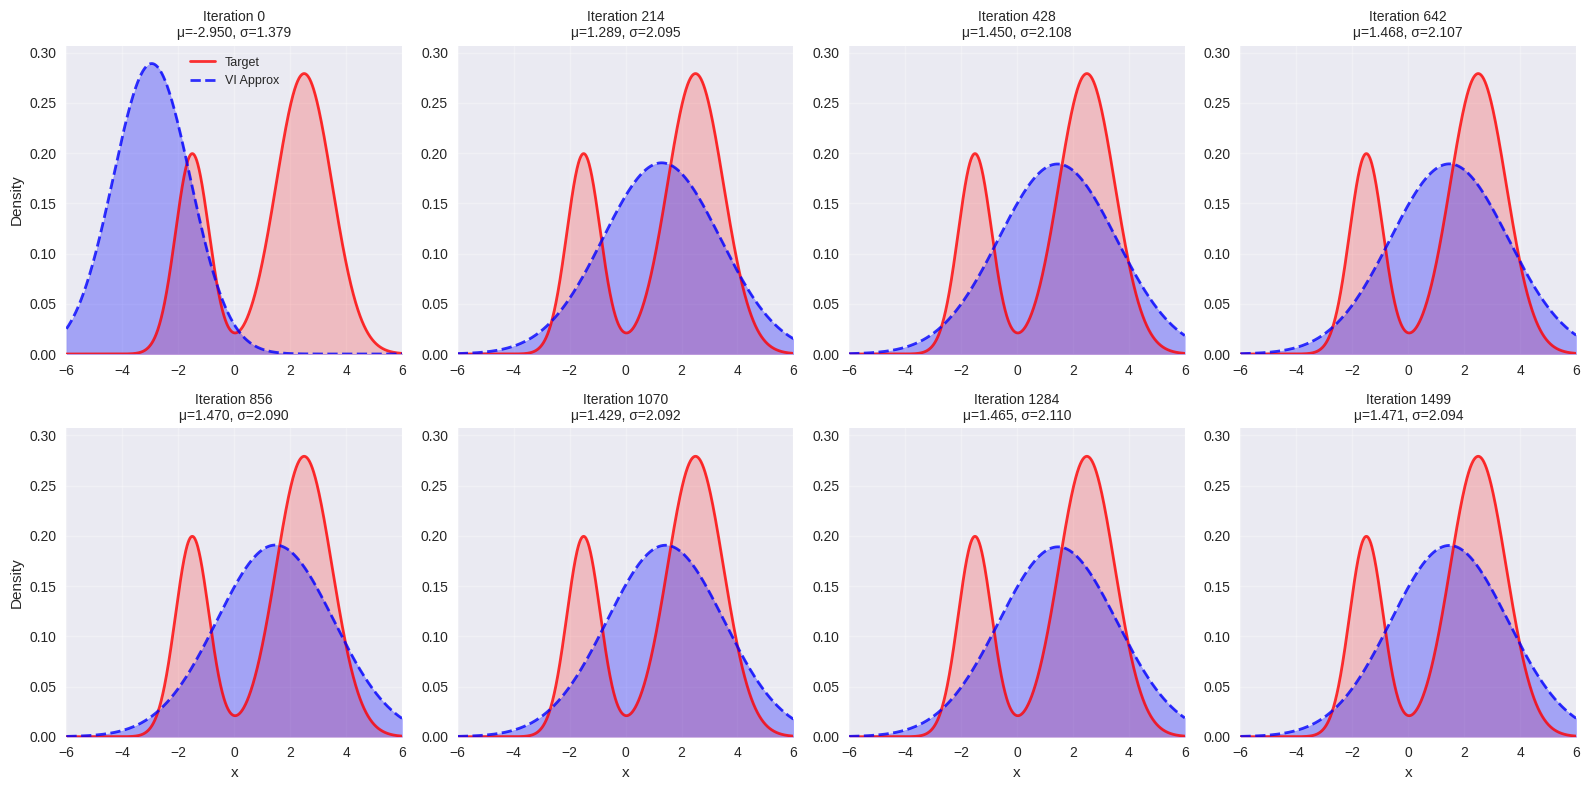


=== Final Results ===
Target mixture: means=[-1.5, 2.5], stds=[0.6, 1.0], weights=[0.3, 0.7]
VI approximation: mean=1.471, std=2.094
Final KL divergence: -1.7390
True mixture moments: mean=1.300, std=2.042
Mean error: 0.171
Std error: 0.053

=== Convergence Analysis ===
Initial loss: 3.9061
Final loss: -1.7390
Loss reduction: 5.6451


In [14]:
print("=== Gaussian Variational Inference with PyTorch ===\n")

# Define target distribution (bimodal Gaussian mixture)
mixture_weights = [0.3, 0.7]
mixture_means = [-1.5, 2.5]
mixture_stds = [0.6, 1.0]

target_fn = lambda x: target_log_density(x, mixture_weights, mixture_means, mixture_stds)

# Run variational inference
vi_model, means_traj, stds_traj, losses = run_variational_inference(
    target_fn,
    n_iterations=1500,
    lr=0.05,
    initial_mean=-3.0,  # Start far from optimum
    initial_log_var=np.log(2.0),  # Initial std = sqrt(2)
    random_seed=42
)

# Demonstrate gradient computation
# compute_analytical_gradients_demo(vi_model, target_fn, n_samples=1000)

# Create comprehensive visualization
print("\nCreating visualization...")
fig = create_visualization(vi_model, means_traj, stds_traj, losses, target_fn,
                           mixture_means, mixture_stds)
plt.show()

# Create evolution sequence
print("Creating evolution sequence...")
fig_seq = create_evolution_sequence(means_traj, stds_traj, target_fn, n_snapshots=8)
plt.show()

# Print final statistics
print(f"\n=== Final Results ===")
print(f"Target mixture: means={mixture_means}, stds={mixture_stds}, weights={mixture_weights}")
final_mean, final_std = vi_model.get_params()
print(f"VI approximation: mean={final_mean:.3f}, std={final_std:.3f}")
print(f"Final KL divergence: {losses[-1]:.4f}")

# Compute some quality metrics
true_mean = sum(w * m for w, m in zip(mixture_weights, mixture_means))
true_var = sum(
    w * (s ** 2 + m ** 2) for w, m, s in zip(mixture_weights, mixture_means, mixture_stds)) - true_mean ** 2
true_std = np.sqrt(true_var)

print(f"True mixture moments: mean={true_mean:.3f}, std={true_std:.3f}")
print(f"Mean error: {abs(final_mean - true_mean):.3f}")
print(f"Std error: {abs(final_std - true_std):.3f}")

# Show convergence analysis
print(f"\n=== Convergence Analysis ===")
print(f"Initial loss: {losses[0]:.4f}")
print(f"Final loss: {losses[-1]:.4f}")
print(f"Loss reduction: {(losses[0] - losses[-1]):.4f}")
